In [1]:
import rasterio
from rasterio.plot import show
import os
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdalconst
import numpy as np
import scipy.signal
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import DBSCAN
import hdbscan
import pandas as pd
from PIL import Image

In [2]:
main_path = os.getcwd()
try:
    os.mkdir('{}\Cube_Images'.format(main_path)) # Hiperspektrālos attēlus ievietot izveidotajā mapē
except:
    print("Directory already exists")

Directory already exists


C:\Users\densl\anaconda3\envs\geo\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


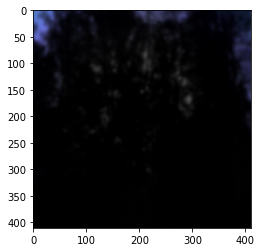

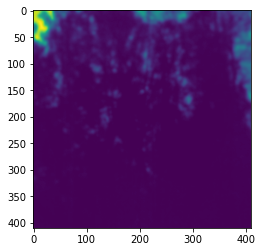

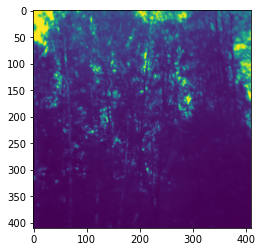

(<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>)

In [3]:
Session = 0
Image_number = 5

image = rasterio.open(r'{}\Cube_Images\session_{:03}_{:03}_snapshot_cube.tiff'.format(main_path,Session,Image_number)) 
show(image), show(image.read(3)), show(image.read(30))

In [4]:
im = gdal.Open(r'{}\Cube_Images\session_{:03}_{:03}_snapshot_cube.tiff'.format(main_path,Session,Image_number)) 

In [5]:
im.RasterCount, im.RasterXSize, im.RasterYSize

(164, 410, 410)

In [6]:
# convert pixel coordinates to geospatial coordinates
def ApplyGeoTransform(inx,iny,gt):
    ''' Apply a geotransform
        @param  inx       Input x coordinate (double)
        @param  iny       Input y coordinate (double)
        @param  gt        Input geotransform (six doubles)
        @return outx,outy Output coordinates (two doubles)
    '''
    outx = gt[0] + inx*gt[1] + iny*gt[2]
    outy = gt[3] + inx*gt[4] + iny*gt[5]
    return (outx,outy)    

In [7]:
try: 
    os.mkdir('{}\Results'.format(main_path))
except:
    print("Directory already exists")

Directory already exists


In [8]:
# SEIT IERAKSTA ATTELA DIREKTORIJU UN IZEJAS DIREKTORIJU DST
Spectral_line = 100

options = {
    'WinRad': int(15), 
    'band_id': int(Spectral_line),
    'MinReflectThres': int(1),
    'suffix': str("reflectance"),
    'src': r'{}\Cube_Images\session_{:03}_{:03}_snapshot_cube.tiff'.format(main_path,Session,Image_number),
    'dst': r'{}\Results'.format(main_path)
    }

In [9]:
def processHSI(options):
    ''' Extract tree positions from canopy height model
        @param  options       Input options (dictionnary)
    '''    
    im = gdal.Open(options['src'], gdalconst.GA_ReadOnly)
    band = im.GetRasterBand(options['band_id'])
    data = band.ReadAsArray(0, 0, im.RasterXSize, im.RasterYSize)
    prj_wkt = im.GetProjectionRef()
    # create kernel
    radius = options['WinRad']#########
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel[mask] = 1
    # compute local maximum image
    data_max = scipy.ndimage.maximum_filter(data, size=None, footprint=kernel, output=None, mode='reflect', cval=0.0, origin=0)
    maxima = (data == data_max) * (data >= options['MinReflectThres'])
    # determine location of local maxima
    labeled, num_objects = scipy.ndimage.label(maxima)
    slices = scipy.ndimage.find_objects(labeled)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2
        y.append(y_center)

    px = np.asarray(x).astype(int) # x coordinate
    py = np.asarray(y).astype(int) # y coordinate
    pz = data[py,px] # reflectance
    geotransform = im.GetGeoTransform()
    mx, my = ApplyGeoTransform(px,py,geotransform)

    return {'xpos':mx, 'ypos':my ,'reflectance':pz, 'prj_wkt':prj_wkt}    

In [10]:
res1 = processHSI(options)

In [11]:
max_reflectance = 4095

In [12]:
res1['xpos'], res1['ypos'], len(res1['xpos']), max(res1['reflectance'])

(array([116., 302., 217., 304., 294., 325.,  20.,  25., 406., 246., 248.,
        362., 303., 317., 235., 251., 319., 337., 198., 277., 328.,   0.,
        242., 197.,  84., 207., 365., 130., 366., 178., 183., 203., 211.,
        187., 184.,  68., 144., 308.,  43., 289., 354., 407., 247.,   0.,
         37.,  30., 213., 223.,  41., 224.,  42., 225.,  44., 366.,  34.,
         78., 209., 384.,  99.,   0., 356., 266., 101., 108., 203., 165.,
        303.,  62., 377., 409., 157.,  21., 110., 172., 338., 221., 230.,
        220.,   1., 189.,  92., 258., 250.,  25., 304., 122., 152., 261.,
        355., 226.,  63., 186., 340., 262., 112., 249., 238.,  17., 231.,
        398.,  84., 132., 154., 200., 257., 275., 237., 331., 392.,  68.,
        223., 132., 403.,  97.,  28., 269., 377., 150., 195., 116., 236.,
         21.,   2., 214., 408.,  44., 302., 263., 377., 132., 337.,  39.,
        177., 151.,  84.,  17., 260., 323.,  59., 390., 354., 263., 181.,
        373., 300., 329., 345.,  81., 

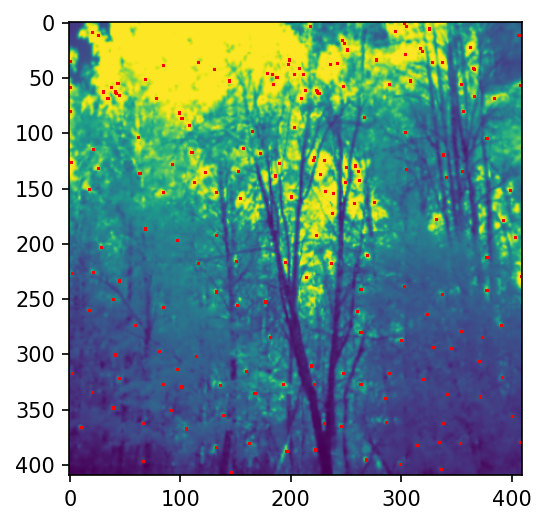

In [13]:
# Create figure and axes
fig, ax = plt.subplots(dpi=150)

# Display the image
ax.imshow(image.read(Spectral_line))
# Create a Rectangle patch
for index, i in enumerate(res1['ypos']):
    x_c = res1['xpos'][int(index)]
    y_c = res1['ypos'][int(index)]
    rect = patches.Rectangle((x_c, y_c), 1, 1, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    #print(str(x_c),str(y_c))

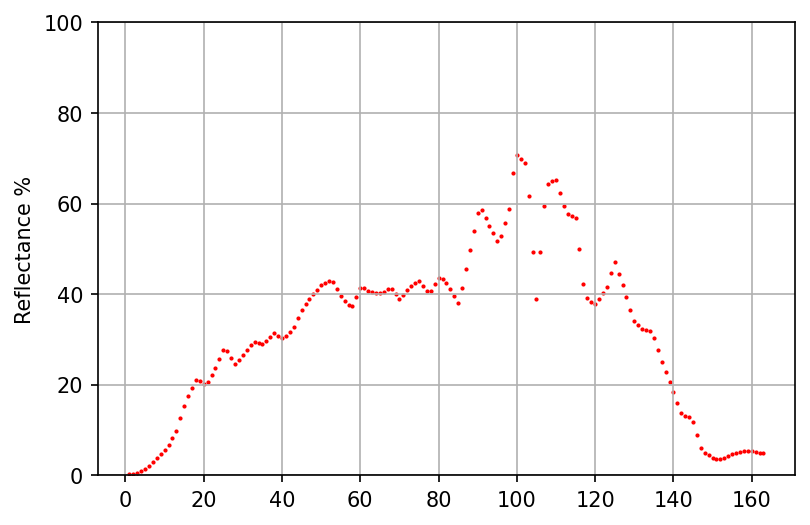

In [14]:
fig, ax = plt.subplots(dpi=150)

kurs_pikselis = 100

X_C = int(res1['xpos'][kurs_pikselis])
Y_C = int(res1['ypos'][kurs_pikselis])

for i in range(1,im.RasterCount):
    good_pix = image.read(i)[X_C][Y_C]/max_reflectance
    ax.scatter(i, good_pix*100, c = 'r', s = 1)
    ax.grid()
    ax.set_ylabel("Reflectance %")
    ax.set_ylim([0,100])
    

In [15]:
Visi_pix = np.zeros((len(res1['xpos']),im.RasterCount))

for k in range(len(res1['xpos'])):

    X_C = int(res1['xpos'][k])
    Y_C = int(res1['ypos'][k])

    for i in range(1,im.RasterCount):
        Visi_pix[k][i] = image.read(i)[X_C][Y_C]

## Klasifikācija

In [16]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=7,min_samples=50,alpha=0.35,metric='euclidean', leaf_size=10)
clusterer.fit(Visi_pix)

HDBSCAN(alpha=0.35, leaf_size=10, min_cluster_size=7, min_samples=50)

In [17]:
a1 = clusterer.labels_
print('Klāsteru skaits ir: ',clusterer.labels_.max()) 

Klāsteru skaits ir:  1


In [18]:
a1

array([-1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  0,  1,  1,  1,  1,  1,  1,
        1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,
        1, -1,  1, -1, -1,  1,  1,  0, -1,  1,  1, -1,  0,  1,  1,  1, -1,
        1,  1,  1, -1, -1,  0,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,
        1, -1,  1,  1,  1, -1, -1,  1,  1,  0,  1,  1, -1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1,
       -1,  0, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
       -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  0,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1, -1], dtype=int64)

In [19]:
rindas = np.zeros([len(res1['xpos']),4+im.RasterCount])

for i in range(0,len(rindas)):
    for k in range(0, im.RasterCount):
        rindas[i][k] = Visi_pix[i][k]
    rindas[i][im.RasterCount + 1] = int(a1[i])
    rindas[i][im.RasterCount + 2] = int(res1['xpos'][i])
    rindas[i][im.RasterCount + 3] = int(res1['ypos'][i])

In [20]:
df = pd.DataFrame(rindas)
df['Attela_ID']='session_{:03}_{:03}_snapshot_cube.tiff'.format(Session,Image_number)
#df = df.round(decimals=0).astype(object)
df = df.rename(columns={im.RasterCount + 1:'Suga',im.RasterCount + 2:'X coord',im.RasterCount + 3:'Y coord'})
df.to_excel('{}\Results\Tabula.xlsx'.format(main_path))
# Nevis suga1,suga2... bet sugas_ID un sugas nosaukums?
# 2 lietas: iet caur visiem attēliem un notiekt labus HDBSCAN parametrus

In [21]:
df

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,Suga,X coord,Y coord,Attela_ID
0,0.0,2.0,2.0,6.0,13.0,20.0,33.0,46.0,59.0,72.0,...,205.0,204.0,203.0,203.0,203.0,0.0,-1.0,116.0,35.0,session_000_005_snapshot_cube.tiff
1,0.0,1.0,1.0,2.0,3.0,5.0,9.0,12.0,16.0,21.0,...,79.0,77.0,77.0,77.0,77.0,0.0,1.0,302.0,0.0,session_000_005_snapshot_cube.tiff
2,0.0,0.0,0.0,1.0,3.0,4.0,9.0,14.0,19.0,24.0,...,136.0,135.0,134.0,134.0,134.0,0.0,1.0,217.0,3.0,session_000_005_snapshot_cube.tiff
3,0.0,0.0,0.0,2.0,5.0,8.0,11.0,14.0,19.0,23.0,...,74.0,72.0,72.0,72.0,72.0,0.0,1.0,304.0,3.0,session_000_005_snapshot_cube.tiff
4,0.0,0.0,0.0,2.0,4.0,7.0,12.0,18.0,23.0,29.0,...,93.0,90.0,90.0,90.0,90.0,0.0,1.0,294.0,7.0,session_000_005_snapshot_cube.tiff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.0,40.0,40.0,77.0,115.0,179.0,272.0,364.0,446.0,529.0,...,203.0,202.0,202.0,202.0,202.0,0.0,-1.0,66.0,396.0,session_000_005_snapshot_cube.tiff
192,0.0,0.0,0.0,1.0,1.0,3.0,5.0,8.0,12.0,15.0,...,90.0,88.0,88.0,88.0,88.0,0.0,1.0,299.0,399.0,session_000_005_snapshot_cube.tiff
193,0.0,1.0,1.0,1.0,1.0,3.0,4.0,6.0,9.0,11.0,...,57.0,57.0,57.0,57.0,57.0,0.0,1.0,409.0,400.0,session_000_005_snapshot_cube.tiff
194,0.0,1.0,1.0,1.0,2.0,3.0,6.0,8.0,12.0,16.0,...,81.0,80.0,80.0,80.0,80.0,0.0,1.0,336.0,404.0,session_000_005_snapshot_cube.tiff


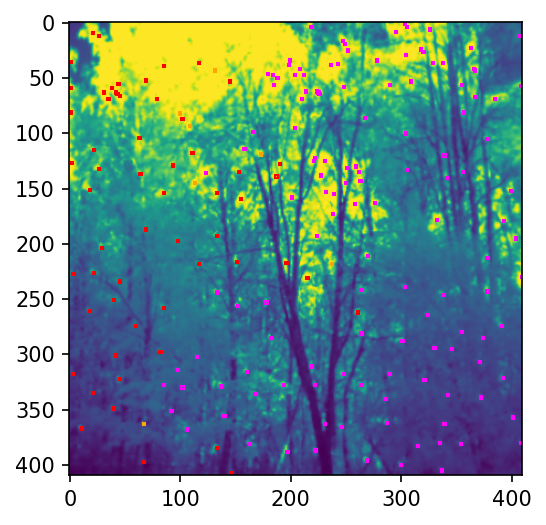

In [22]:
# Create figure and axes
fig, ax = plt.subplots(dpi=150)

cmap = ['red','orange','magenta']

# Display the image
ax.imshow(image.read(Spectral_line))
# Create a Rectangle patch
for index, i in enumerate(res1['ypos']):
    x_c = res1['xpos'][int(index)]
    y_c = res1['ypos'][int(index)]
    rect = patches.Rectangle((x_c, y_c), 2, 2, linewidth=1, edgecolor=cmap[a1[index]+1], facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    #print(str(x_c),str(y_c))

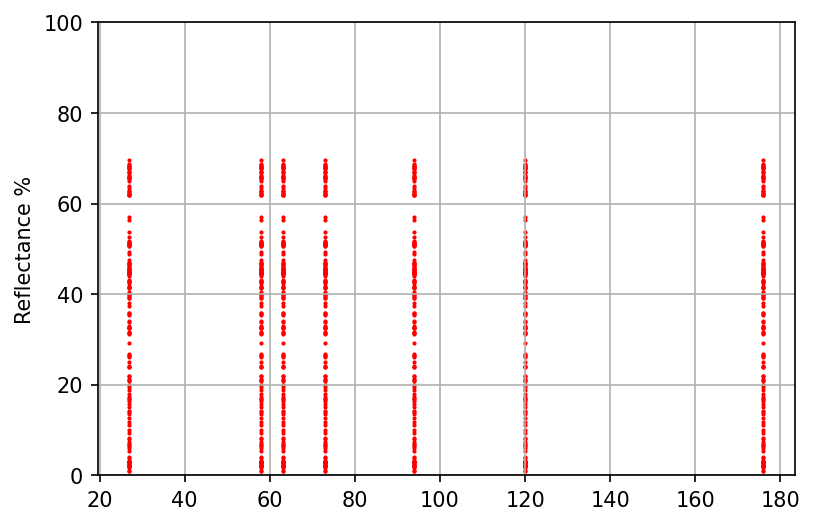

In [30]:
fig, ax = plt.subplots(dpi=150)

for i in range(len(a1)):
    if a1[i]==0:
        for k in range(1,im.RasterCount):
            good_pix = image.read(k)[X_C][Y_C]/max_reflectance
            ax.scatter(i, good_pix*100, c = 'r', s = 1)
            ax.grid()
            ax.set_ylabel("Reflectance %")
            ax.set_ylim([0,100])

### RGB attēls

In [35]:
red_im = Image.fromarray(image.read(86)/10).convert('L')
blue_im = Image.fromarray(image.read(22)/10).convert('L')
green_im = Image.fromarray(image.read(49)/10).convert('L')

In [36]:
rgb = Image.merge("RGB",(red_im,green_im,blue_im))

In [37]:
rgb_array = np.array(rgb)

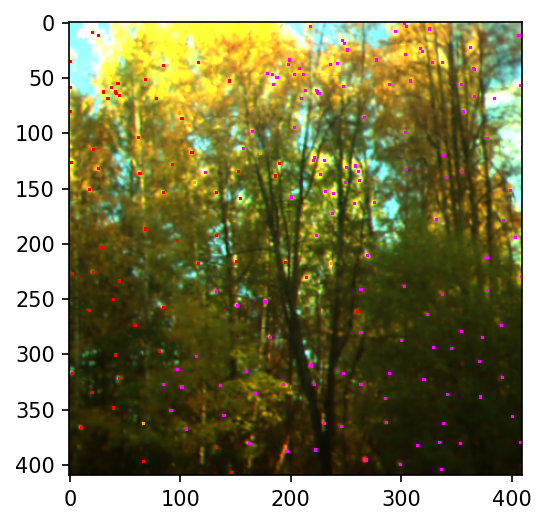

In [38]:
# Create figure and axes
fig, ax = plt.subplots(dpi=150)

cmap = ['red','orange','magenta']

# Display the image
ax.imshow(rgb_array)
# Create a Rectangle patch
for index, i in enumerate(res1['ypos']):
    x_c = res1['xpos'][int(index)]
    y_c = res1['ypos'][int(index)]
    rect = patches.Rectangle((x_c, y_c), 1, 1, linewidth=1, edgecolor=cmap[a1[index]+1], facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    #print(str(x_c),str(y_c))

## Visi attēli

In [21]:
main_path = os.getcwd()
try:
    os.mkdir('{}\Cube_Images'.format(main_path)) # Hiperspektrālos attēlus ievietot izveidotajā mapē
except:
    print("Directory already exists")

Directory already exists


In [22]:
directory = '{}\Cube_Images'.format(main_path)

attelu_skaits = 0

for filename in os.scandir(directory):
    if filename.is_file():
        attelu_skaits += 1
        print(filename.path)

C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_000_005_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_000_026_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_005_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_012_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_015_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_016_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_017_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_018_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_019_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_020_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuff\Prakse\Cube_Images\session_001_021_snapshot_cube.tiff
C:\Users\densl\Documents\LU Stuf

In [23]:
attelu_skaits

38

In [24]:
def image_rasterio_read(filename):
    image = rasterio.open(r'{}'.format(filename.path)) 
    return image

In [25]:
def image_read(filename):
    im = gdal.Open(r'{}'.format(filename.path))
    return im

In [28]:
def spectral_options(spectral_line):
    options = {
    'WinRad': int(15), 
    'band_id': int(spectral_line),
    'MinReflectThres': int(1),
    'suffix': str("reflectance"),
    'src': r'{}\Cube_Images\session_{:03}_{:03}_snapshot_cube.tiff'.format(main_path,Session,Image_number),
    'dst': r'{}\Results'.format(main_path)
    }
    res = processHSI(options)
    return res